In [1]:
import pandas as pd
import random
import math

data = pd.read_csv('../data/ts_SC_OH_10_to_19_no17_class_mv_idx_stat.csv')
data.head()

,index,yield,radiation,rain,avg_min_temp,avg_max_temp,class
0,1,-0.609000,244241.54,2239.92,5.165557,16.243119,1
1,2,0.438333,255616.65,2365.86,5.618764,16.689609,1
2,3,-0.040500,269016.87,2574.02,6.122322,17.216131,1
3,4,0.109833,285825.46,2634.73,6.606260,17.790725,0
4,5,-0.502000,361996.10,3569.09,5.291709,16.347207,1


In [2]:
# from sdv.tabular import TVAE

# model = TVAE()
# model.fit(data)

samples_out = 30 # total number of samples/records to generate/synthesize
no_stds = 2 # number of standard deviations within which synthesized values must fall
number_of_classes = (data['class'].unique()).size # number of unique classes in input data

data_len = len(data.index)
F = [] # a list of the feature vectors dataframes, one per class
for class_no in range(number_of_classes):
    df = pd.DataFrame(data[data['class'] == class_no])
    F.append(df)

    
def synthesize_tabular_data(F, samples_out, no_stds, no_classes, no_records):
    new_F = []
    for index, entry in enumerate(F):
        yield_ = entry['yield']
        mean_yield = yield_.mean()
        std_yield = yield_.std()
        total_rad = entry['radiation']
        mean_rad = total_rad.mean()
        std_rad = total_rad.std()
        total_rain = entry['rain']
        mean_rain = total_rain.mean()
        std_rain = total_rain.std()
        avg_max_temp = entry['avg_max_temp']
        mean_max_temp = avg_max_temp.mean()
        std_max_temp = avg_max_temp.std()
        avg_min_temp = entry['avg_min_temp']
        mean_min_temp = avg_min_temp.mean()
        std_min_temp = avg_min_temp.std()
        
        new_yields = []
        new_rads = []
        new_rains = []
        new_max_temps = []
        new_min_temps = []
        
        # calculate potcii: percentage of this class in input
        potcii = (len(entry)/no_records)
        no_records_to_generate = round(potcii * samples_out)
        
        for i in range(no_records_to_generate):
            new_yield = random.uniform(mean_yield - std_yield*no_stds, mean_yield + std_yield*no_stds)
            new_yields.append(new_yield)
            
            new_rad = random.uniform(mean_rad - std_rad*no_stds, mean_rad + std_rad*no_stds)
            new_rads.append(new_rad)
            
            new_rain = random.uniform(mean_rain - std_rain*no_stds, mean_rain + std_rain*no_stds)
            new_rains.append(new_rain)
        
            new_max_temp = random.uniform(mean_max_temp - std_max_temp*no_stds, mean_max_temp + std_max_temp*no_stds)
            new_max_temps.append(new_max_temp)
            
            new_min_temp = random.uniform(mean_min_temp - std_min_temp*no_stds, mean_min_temp + std_min_temp*no_stds)
            new_min_temps.append(new_min_temp)
            
        new_yields_series = pd.Series(new_yields, name="Yield (tons/acre)")
        new_rads_series = pd.Series(new_rads, name="Total Radiation (W/m^2)")
        new_rains_series = pd.Series(new_rains, name="Total Rainfall (mm)")
        new_max_temps_series = pd.Series(new_max_temps, name="Avg Max Temp (C)")
        new_min_temps_series = pd.Series(new_min_temps, name="Avg Min Temp (C)")
        
        concat_yields = pd.concat([yield_, new_yields_series])
        concat_rads = pd.concat([total_rad, new_rads_series])
        concat_rain = pd.concat([total_rain, new_rains_series])
        concat_max_temps = pd.concat([avg_max_temp, new_max_temps_series])
        concat_min_temps = pd.concat([avg_min_temp, new_min_temps_series])
        new_df = pd.DataFrame()
        new_df['yield'] = concat_yields
        new_df['radiation'] = concat_rads
        new_df['rain'] = concat_rain
        new_df['avg_max_temp'] = concat_max_temps
        new_df['avg_min_temp'] = concat_min_temps
        new_df['class'] = index
        print(index)
        new_F.append(new_df)
        
    return pd.concat(new_F)

new_data = synthesize_tabular_data(F, samples_out, no_stds, number_of_classes, data_len)

0
1
2


In [3]:
# new_data = model.sample(10000)

In [4]:
new_data.to_csv('data/FDA_XGB_boost_SITS_2k_0623_SC_2_Woos_OH.csv')
new_data.head()

,yield,radiation,rain,avg_max_temp,avg_min_temp,class
3,0.109833,285825.46,2634.73,17.790725,6.606260,0
6,-0.553000,383493.75,3817.77,16.934736,5.859211,0
7,-0.142000,400987.90,3982.19,17.349952,6.248983,0
11,-0.286923,120950.35,1272.58,18.398237,6.756974,0
15,0.373077,236439.38,2431.70,17.137343,5.891001,0


In [5]:
# get aggregate data
targetDataLoc = '../data/ts_Woos_OH_18_stat.csv'

targetDf = pd.read_csv(targetDataLoc) #pd.read_csv(targetDataLoc)
aggDf = new_data #pd.read_csv(aggDataLoc)
boostDataLoc = '../data/ts_Woos_OH_11_to_17_stat.csv'
boostDf = pd.read_csv(boostDataLoc)
targetDf.head()

,index,yield,radiation,rain,avg_min_temp,avg_max_temp,class
0,1,-1.390667,233501.80,2194.04,5.513855,16.814316,1
1,2,0.002000,247205.72,2351.24,6.029286,17.322932,1
2,3,-0.152000,258669.97,2432.13,6.430434,17.731435,1
3,4,0.187333,271435.51,2521.06,6.890394,18.184850,1


In [6]:
all_years_Loc = '../data/ts_Wooster_OH_11_to_18_class_mv_idx_ylds.csv'
all_yearsDf = pd.read_csv(all_years_Loc)
final_year_Loc = '../data/Wooster_OH_avg_ylds_for_math_mv_11_to_17.csv'
final_yearDf = pd.read_csv(final_year_Loc)
final_yearDf.head()
target_year_Loc = '../data/ts_Wooster_OH_2018_ylds_mv_idx.csv'
target_yearDf = pd.read_csv(target_year_Loc)

In [7]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVC  # support vector machines classification
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier # neural network for classification
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost for classification
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib

# import the API
APILoc = 'API/'

import sys
sys.path.insert(0, APILoc)

from API import *

In [8]:
# filter out the features that will not be used by the machine learning models

xColumnsToKeep = ["radiation","rain", "avg_max_temp", "avg_min_temp"]

# the target to keep
yColumnsToKeep = ["yield"]

# get a dataframe containing the features and the targets
xDf = aggDf[xColumnsToKeep]
test_xDf = targetDf[xColumnsToKeep]
boost_xDf = boostDf[xColumnsToKeep]

yDf = aggDf[yColumnsToKeep]
test_yDf = targetDf[yColumnsToKeep]
boost_yDf = boostDf[yColumnsToKeep]

# reset the index
xDf = xDf.reset_index(drop=True)
yDf = yDf.reset_index(drop=True)
test_xDf = test_xDf.reset_index(drop=True)
test_yDf = test_yDf.reset_index(drop=True)
boost_xDf = boost_xDf.reset_index(drop=True)
boost_yDf = boost_yDf.reset_index(drop=True)

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)

xCols = list(xDf)

In [9]:
# hide the warnings because training the neural network caues lots of warnings.
import warnings
warnings.filterwarnings('ignore')

# make the parameter grids for sklearn's gridsearchcv
rfParamGrid = {
        'model__n_estimators': [5, 10, 25, 50, 100], # Number of estimators
        'model__max_depth': [5, 10, 15, 20], # Maximum depth of the tree
        'model__criterion': ["mae"]
    }
knnParamGrid ={
        'model__n_neighbors':[2,5,10],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [5, 10, 30, 50]    
    }
svrParamGrid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 5.0, 10.0],
        'model__gamma': ["scale", "auto"],
        'model__degree': [2,3,4,5]
    }
nnParamGrid = {
        'model__hidden_layer_sizes':[(3), (5), (10), (3,3), (5,5), (7,7)],
        'model__solver': ['sgd', 'adam'],
        'model__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'model__learning_rate_init': [0.1, 0.01, 0.001]      
    }

linRegParamGrid = {}

bayesParamGrid={
        'model__n_iter':[100,300,500]
    }

dtParamGrid = {
    'model__criterion': ['mae'],
    'model__max_depth': [5,10,25,50,100]
    }

xgbParamGrid = {}

aModelList = [#(RandomForestRegressor(), rfParamGrid, "rfTup.pkl")]#,
              #(KNeighborsRegressor(), knnParamGrid, "knnTup.pkl"),
              #(SVC(), svrParamGrid, "svrTup.pkl")]#,
             #(MLPClassifier(), nnParamGrid, "nnTup.pkl")]#,
             #(LinearRegression(), linRegParamGrid, "linRegTup.pkl")]#,
             #(BayesianRidge(), bayesParamGrid, "bayesTup.pkl"),
             #(DecisionTreeRegressor(), dtParamGrid, "dtTup.pkl")]
             (xgb.XGBRegressor(), xgbParamGrid, "xgbTup.pkl")]

N = 3
workingDir = 'working_dir'
numFeatures = 4 # 11

model:  xgbTup
Avg MAE:  999.26
Avg R squared:  0.046
Best MAE:  1189.255
Best R squared:  0.186
 
test results on our test data: 
      yield
0 -1.390667
1  0.002000
2 -0.152000
3  0.187333
[-0.13144255  0.39628422  0.19466728 -0.37373552]
adjusted predictions: 
[2.2467609161555178, 2.3113621446028443, 1.7188707427203065, 0.6807753057365875]
          0
0  2.246761
1  2.311362
2  1.718871
3  0.680775
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     2.445
Date:                Sun, 06 Oct 2024   Prob (F-statistic):              0.258
Time:                        23:04:15   Log-Likelihood:                 2.0839
No. Observations:                   4   AIC:                           -0.1678
Df Residuals:                       2   BI

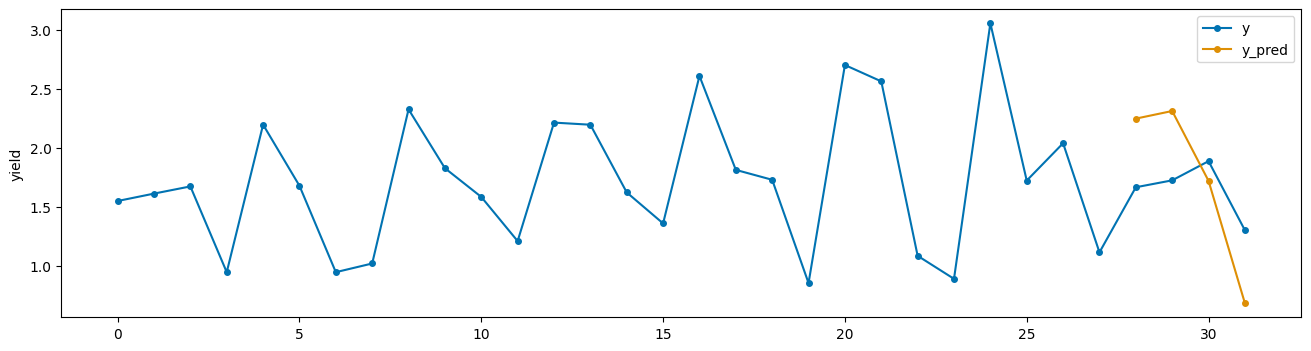

In [10]:
saveMLResults(all_yearsDf, final_yearDf, target_yearDf, boost_xDf, boost_yDf, test_xDf, test_yDf, N, xDf, yDf, aModelList, workingDir, numFeatures, printResults=True)